# 9. Comparative Feature Analysis

This notebook analyzes the relationships between features *within* each dataset (modality/view) and *between* the different datasets.

**Goals:**
1.  Assess the correlation between color (spectral) traits and morphological traits within each view.

2.  Assess the consistency of measurements between the different views (e.g., how well does side view area correlate with top view area?).

In [24]:
# Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# Load Merged Data 
try:
    merged_df = pd.read_csv('../results/data/merged_all_datasets.csv')
    print("Merged data loaded successfully.")
    # Convert Date column back if needed, though not strictly necessary for correlations
    # merged_df['Date'] = pd.to_datetime(merged_df['Date'])
except FileNotFoundError:
    print("Error: 'merged_all_datasets.csv' not found.")
    print("Please run notebook '00_data_integration.ipynb' first.")

Merged data loaded successfully.


In [26]:
# Define Key Features (Expanded)

# Define the base names of features you want to compare
# Add all the morphological features you want to see
morph_features_base = ['area', 'height', 'perimeter', 'convex_hull_area', 'solidity']
# Add all the color/spectral features you want to see
color_features_base = ['blue_yellow_mean', 'green_red_mean', 'red_mean', 'green_mean', 'blue_mean', 'hue_mean', 'saturation_mean']

# Define the suffixes used during merging
suffixes = ['_side_old', '_side_new', '_top_new']

# Generate the full list of suffixed column names (no change here)
all_morph_features = [f"{feat}{suf}" for feat in morph_features_base for suf in suffixes]
all_color_features = [f"{feat}{suf}" for feat in color_features_base for suf in suffixes]

print(f"Tracking {len(morph_features_base)} morph features and {len(color_features_base)} color features across {len(suffixes)} datasets.")

Tracking 5 morph features and 7 color features across 3 datasets.


## Goal 1: Within-Dataset Correlations (Color vs. Morphology)
We will create a heatmap for each dataset showing the correlation between its color and morphological features.


--- Correlations for Dataset: _side_old ---


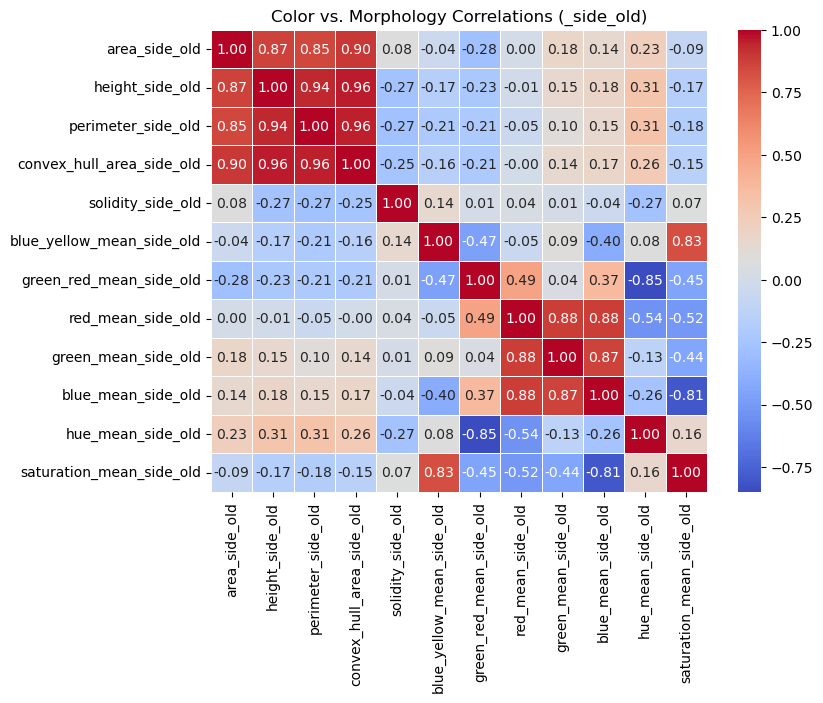


--- Correlations for Dataset: _side_new ---


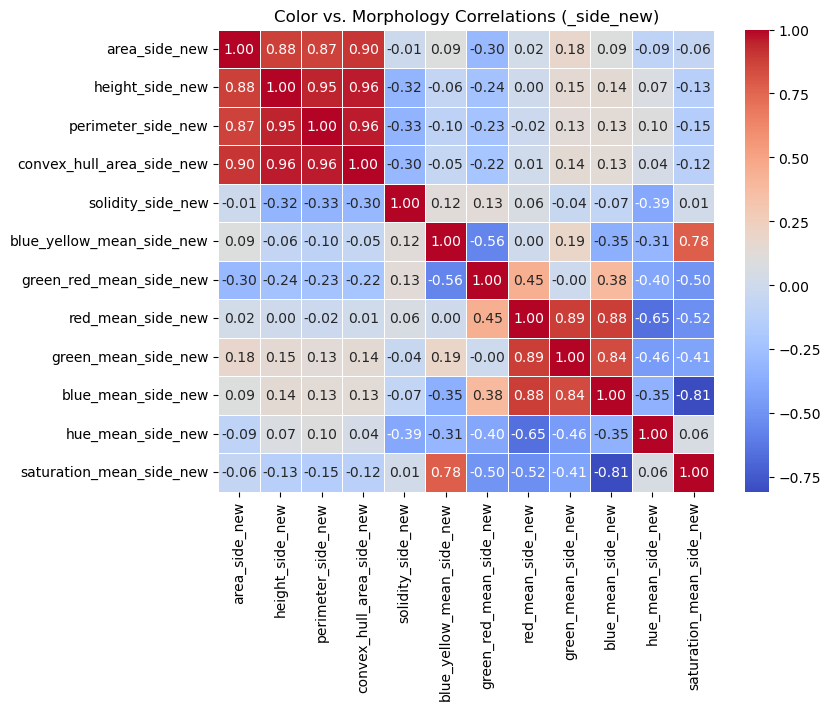


--- Correlations for Dataset: _top_new ---


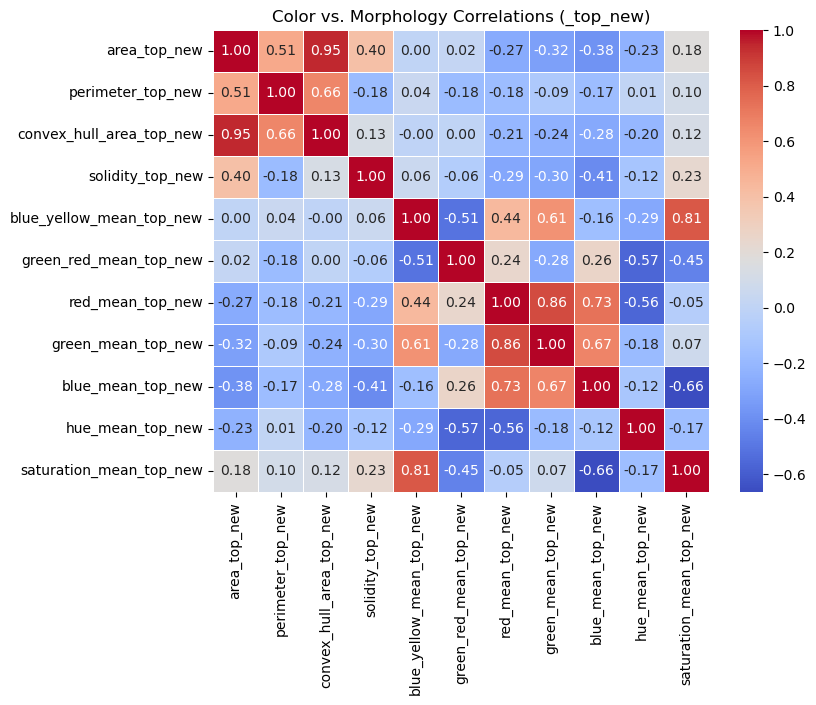

In [27]:
# Within-Dataset Heatmaps
for suffix in suffixes:
    print(f"\n--- Correlations for Dataset: {suffix} ---")
    
    # Select columns for this specific dataset
    morph_cols = [f"{feat}{suffix}" for feat in morph_features_base]
    color_cols = [f"{feat}{suffix}" for feat in color_features_base]
    cols_subset = morph_cols + color_cols
    
    # Check if columns exist before calculating correlation
    existing_cols = [col for col in cols_subset if col in merged_df.columns]
    if len(existing_cols) < 2:
        print(f"Not enough columns found for {suffix} to calculate correlations. Skipping.")
        continue
        
    subset_df = merged_df[existing_cols].dropna() # Drop rows with any NaNs for correlation calc
    
    if subset_df.empty:
        print(f"No non-missing data found for correlation in {suffix}. Skipping.")
        continue

    # Calculate correlation matrix
    corr_matrix = subset_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Color vs. Morphology Correlations ({suffix})')
    plt.show()

## Goal 2: Between-Dataset Correlations (Feature Consistency)
We will create a heatmap showing how well key features (like 'area') correlate across the different datasets/views.


--- Comparing 'area' Across Datasets ---


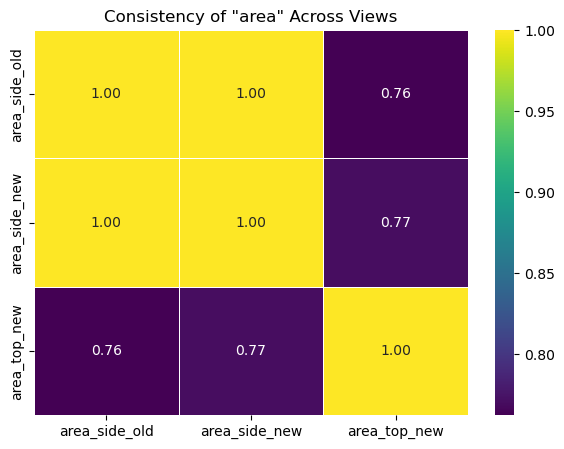


--- Comparing 'height' Across Datasets ---


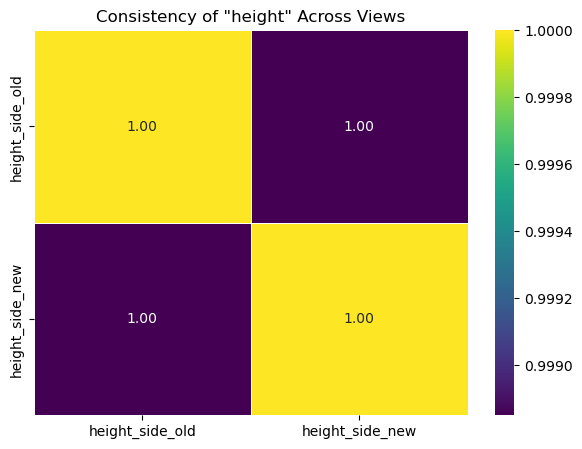


--- Comparing 'perimeter' Across Datasets ---


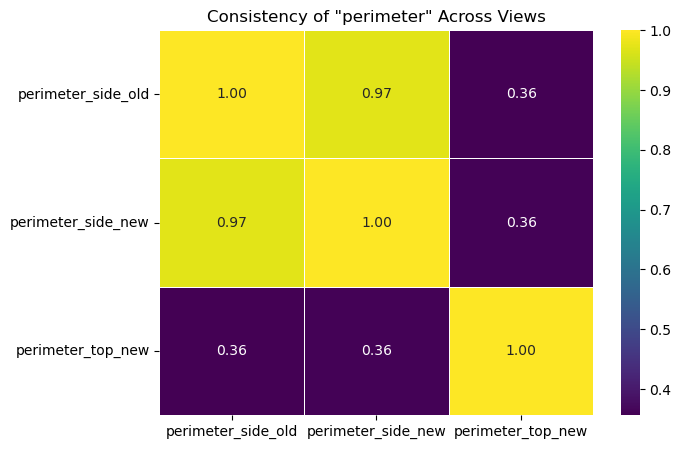


--- Comparing 'convex_hull_area' Across Datasets ---


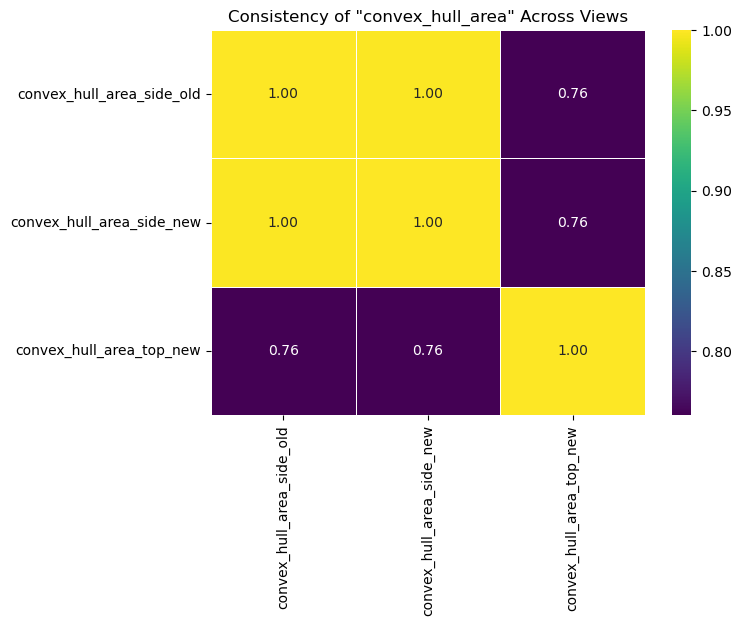


--- Comparing 'solidity' Across Datasets ---


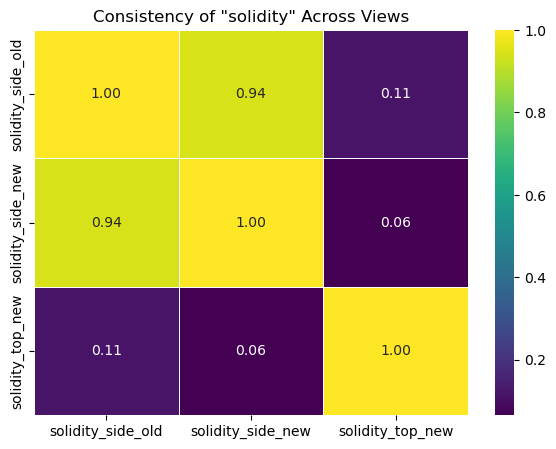

In [28]:
# Between-Dataset Correlations (All Morph Features) 

# Loop through each base morphological feature to compare it across datasets
for feature_to_compare in morph_features_base:
    compare_cols = [f"{feature_to_compare}{suf}" for suf in suffixes if f"{feature_to_compare}{suf}" in merged_df.columns]

    if len(compare_cols) < 2:
        print(f"\nSkipping '{feature_to_compare}': Not found in multiple datasets.")
        continue

    print(f"\n--- Comparing '{feature_to_compare}' Across Datasets ---")
    compare_df = merged_df[compare_cols].dropna()
    
    if compare_df.empty:
         print(f"No non-missing overlapping data found for '{feature_to_compare}'.")
    else:
        corr_matrix_between = compare_df.corr()
        
        plt.figure(figsize=(7, 5))
        sns.heatmap(corr_matrix_between, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
        plt.title(f'Consistency of "{feature_to_compare}" Across Views')
        plt.show()

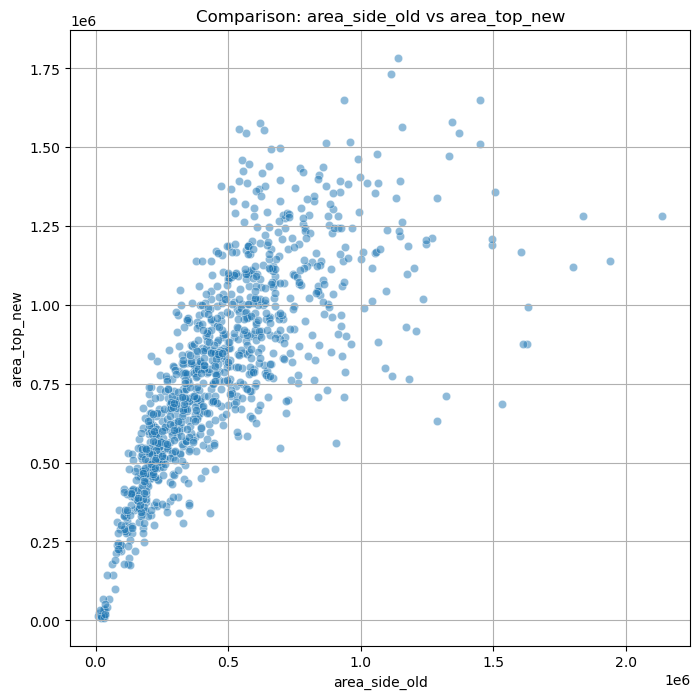

In [29]:
#  Scatter Plot for Key Comparison
# Example: Compare old side area vs. new top area
col1 = 'area_side_old'
col2 = 'area_top_new'

if col1 in merged_df.columns and col2 in merged_df.columns:
    plt.figure(figsize=(8, 8))
    # Use a sample to avoid overplotting if the dataset is large
    sample_df = merged_df.sample(min(1000, len(merged_df)), random_state=42)
    sns.scatterplot(data=sample_df, x=col1, y=col2, alpha=0.5)
    plt.title(f'Comparison: {col1} vs {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.grid(True)
    plt.show()
else:
    print(f"\nSkipping scatter plot: Columns {col1} or {col2} not found.")

In [30]:
# Calculate Overall Dataset Similarity 

from scipy.stats import pearsonr

print("\n--- Overall Dataset Similarity Scores ---")

# Get a list of all base feature names (morph + color)
all_base_features = list(set(morph_features_base + color_features_base))

# Iterate through all pairs of datasets (e.g., old_side vs new_side)
from itertools import combinations
for suf1, suf2 in combinations(suffixes, 2):
    
    correlations = []
    # Find all common features between these two datasets
    for base_feat in all_base_features:
        col1 = f"{base_feat}{suf1}"
        col2 = f"{base_feat}{suf2}"
        
        # Check if both columns exist in the dataframe
        if col1 in merged_df.columns and col2 in merged_df.columns:
            # Drop NaNs for this pair of columns
            pair_df = merged_df[[col1, col2]].dropna()
            if not pair_df.empty:
                # Calculate correlation and add it to our list
                corr, _ = pearsonr(pair_df[col1], pair_df[col2])
                correlations.append(corr)
    
    # Calculate the average correlation across all common features
    if correlations:
        avg_corr = np.mean(correlations)
        print(f"Average Correlation between {suf1} and {suf2}: {avg_corr:.3f}")
    else:
        print(f"No common features found between {suf1} and {suf2}.")


--- Overall Dataset Similarity Scores ---
Average Correlation between _side_old and _side_new: 0.960
Average Correlation between _side_old and _top_new: 0.396
Average Correlation between _side_new and _top_new: 0.412


# Goal 3: Predictive Modeling (Color vs. Morphology)

Let's test how well spectral (color) features can predict a key morphological feature ('area') and vice versa. We will include 'Days_Since_2024_05_26' as a feature to give the model critical time context.

In [31]:
# Predictive Modeling Setup 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings

# Suppress warnings from models for cleaner output
warnings.filterwarnings('ignore')

# --- Loop through each dataset to build and test models ---
for suffix in suffixes:
    print(f"\n--- Predictive Modeling for Dataset: {suffix} ---")
    
    # Define features (X) and targets (y) for this dataset
    morph_cols = [f"{feat}{suffix}" for feat in morph_features_base if f"{feat}{suffix}" in merged_df.columns]
    color_cols = [f"{feat}{suffix}" for feat in color_features_base if f"{feat}{suffix}" in merged_df.columns]
    
    # Define the primary target for morphology
    morph_target = f'area{suffix}'
    
    if morph_target not in merged_df.columns:
        print("Skipping: 'area' feature not found.")
        continue
        
    # --- Model 1: Can Color predict Area? ---
    if color_cols:
        model_df = merged_df[color_cols + [morph_target]].dropna()
        if not model_df.empty:
            X = model_df[color_cols]
            y = model_df[morph_target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Model 1 (Color -> Area) R-squared: {r2:.3f}")
        else:
            print("  Skipping Model 1: No complete data for color -> area.")
    
    # --- Model 2: Can Morphology predict Color? ---
    # We'll pick one key color feature to predict: 'green_red_mean'
    color_target = f'green_red_mean{suffix}'
    
    if color_target in merged_df.columns and morph_cols:
        model_df = merged_df[morph_cols + [color_target]].dropna()
        if not model_df.empty:
            X = model_df[morph_cols]
            y = model_df[color_target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Model 2 (Morph -> Green-Red) R-squared: {r2:.3f}")
        else:
            print("  Skipping Model 2: No complete data for morph -> green_red.")
            
# Turn warnings back on
warnings.filterwarnings('default')


--- Predictive Modeling for Dataset: _side_old ---
  Model 1 (Color -> Area) R-squared: 0.217
  Model 2 (Morph -> Green-Red) R-squared: 0.432

--- Predictive Modeling for Dataset: _side_new ---
  Model 1 (Color -> Area) R-squared: 0.335
  Model 2 (Morph -> Green-Red) R-squared: 0.488

--- Predictive Modeling for Dataset: _top_new ---
  Model 1 (Color -> Area) R-squared: 0.407
  Model 2 (Morph -> Green-Red) R-squared: 0.234


In [32]:
# Predictive Modeling Setup (with Time as a Feature)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings

# Suppress warnings from models for cleaner output
warnings.filterwarnings('ignore')

# --- Loop through each dataset to build and test models ---
for suffix in suffixes:
    print(f"\n--- Predictive Modeling for Dataset: {suffix} ---")
    
    # Define features (X) and targets (y) for this dataset
    morph_cols_base = [f"{feat}{suffix}" for feat in morph_features_base if f"{feat}{suffix}" in merged_df.columns]
    color_cols_base = [f"{feat}{suffix}" for feat in color_features_base if f"{feat}{suffix}" in merged_df.columns]
    
    # Add the 'Days' column to our feature lists
    time_col = 'Days_Since_2024_05_26'
    
    morph_cols = morph_cols_base + [time_col]
    color_cols = color_cols_base + [time_col]
    
    # Define the primary target for morphology
    morph_target = f'area{suffix}'
    
    if morph_target not in merged_df.columns:
        print("Skipping: 'area' feature not found.")
        continue
        
    # --- Model 1: Can Color + Time predict Area? ---
    if color_cols:
        model_df = merged_df[color_cols + [morph_target]].dropna()
        if not model_df.empty and len(model_df) > 10:
            X = model_df[color_cols]
            y = model_df[morph_target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Model 1 (Color + Time -> Area) R-squared: {r2:.3f}")
        else:
            print("  Skipping Model 1: No complete data for color -> area.")
    
    # --- Model 2: Can Morphology + Time predict Color? ---
    color_target = f'green_red_mean{suffix}'
    
    if color_target in merged_df.columns and morph_cols:
        model_df = merged_df[morph_cols + [color_target]].dropna()
        if not model_df.empty and len(model_df) > 10:
            X = model_df[morph_cols]
            y = model_df[color_target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Model 2 (Morph + Time -> Green-Red) R-squared: {r2:.3f}")
        else:
            print("  Skipping Model 2: No complete data for morph -> green_red.")
            
# Turn warnings back on
warnings.filterwarnings('default')


--- Predictive Modeling for Dataset: _side_old ---
  Model 1 (Color + Time -> Area) R-squared: 0.472
  Model 2 (Morph + Time -> Green-Red) R-squared: 0.536

--- Predictive Modeling for Dataset: _side_new ---
  Model 1 (Color + Time -> Area) R-squared: 0.604
  Model 2 (Morph + Time -> Green-Red) R-squared: 0.586

--- Predictive Modeling for Dataset: _top_new ---
  Model 1 (Color + Time -> Area) R-squared: 0.510
  Model 2 (Morph + Time -> Green-Red) R-squared: 0.399


# Goal 3: Predictive Modeling (Color vs. Morphology) 

Our previous attempts showed that static features are weak and delta features are too noisy.

Our best model so far (Color + Time -> Area) is still weak because it's trying to find one rule for all 60 genotypes.

**Final Attempt:** We will now add **Genotype** as a feature to allow the model to learn different rules for each genetic line.

In [ ]:
# Predictive Modeling Setup (with Time + Genotype as Features)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings

# Suppress warnings from models for cleaner output
warnings.filterwarnings('ignore')

# --- Step 1: Prepare the data with Genotype dummies ---

# 'Plant.Genotype' should already be in merged_df from our integration step
# We need to turn this categorical feature into numbers using one-hot encoding
if 'Plant.Genotype' in merged_df.columns:
    genotype_dummies = pd.get_dummies(merged_df['Plant.Genotype'], prefix='geno')
    merged_df_with_dummies = pd.concat([merged_df, genotype_dummies], axis=1)
    genotype_cols = list(genotype_dummies.columns)
    print(f"Successfully added {len(genotype_cols)} genotype features.")
else:
    print("Warning: 'Plant.Genotype' column not found. Proceeding without genotype features.")
    merged_df_with_dummies = merged_df
    genotype_cols = []


# --- Step 2: Loop through each dataset to build and test models ---
for suffix in suffixes:
    print(f"\n--- Predictive Modeling for Dataset: {suffix} ---")
    
    # Define features (X) and targets (y) for this dataset
    morph_cols_base = [f"{feat}{suffix}" for feat in morph_features_base if f"{feat}{suffix}" in merged_df.columns]
    color_cols_base = [f"{feat}{suffix}" for feat in color_features_base if f"{feat}{suffix}" in merged_df.columns]
    
    # Add the 'Days' column AND all 'geno_' columns to our feature lists
    time_col = 'Days_Since_2024_05_26'
    
    # Features for Model 1
    color_features = color_cols_base + [time_col] + genotype_cols
    # Features for Model 2
    morph_features = morph_cols_base + [time_col] + genotype_cols
    
    morph_target = f'area{suffix}'
    color_target = f'green_red_mean{suffix}'
    
    if morph_target not in merged_df.columns:
        print("Skipping: 'area' feature not found.")
        continue
        
    # --- Model 1: Can (Color + Time + Genotype) predict Area? ---
    if color_cols_base: # Check if base color columns exist
        model_df = merged_df_with_dummies[color_features + [morph_target]].dropna()
        if not model_df.empty and len(model_df) > 10:
            X = model_df[color_features]
            y = model_df[morph_target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Model 1 (Color + Time + Geno -> Area) R-squared: {r2:.3f}")
        else:
            print("  Skipping Model 1: No complete data.")
    
    # --- Model 2: Can (Morphology + Time + Genotype) predict Color? ---
    if color_target in merged_df.columns and morph_cols_base: # Check if base morph columns exist
        model_df = merged_df_with_dummies[morph_features + [color_target]].dropna()
        if not model_df.empty and len(model_df) > 10:
            X = model_df[morph_features]
            y = model_df[color_target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Model 2 (Morph + Time + Geno -> Green-Red) R-squared: {r2:.3f}")
        else:
            print("  Skipping Model 2: No complete data.")
            
# Turn warnings back on
warnings.filterwarnings('default')

Successfully added 60 genotype features.

--- Predictive Modeling for Dataset: _side_old ---
  Model 1 (Color + Time + Geno -> Area) R-squared: 0.611
  Model 2 (Morph + Time + Geno -> Green-Red) R-squared: 0.631

--- Predictive Modeling for Dataset: _side_new ---
  Model 1 (Color + Time + Geno -> Area) R-squared: 0.656
  Model 2 (Morph + Time + Geno -> Green-Red) R-squared: 0.676

--- Predictive Modeling for Dataset: _top_new ---
  Model 1 (Color + Time + Geno -> Area) R-squared: 0.651
  Model 2 (Morph + Time + Geno -> Green-Red) R-squared: 0.678
